In [13]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [14]:
def compute_leaf_metrics(segmented_image, mask):
    mask = (mask > 0).astype(np.uint8)
    leaf_pixels = cv2.bitwise_and(segmented_image, segmented_image, mask=mask)
    hsv = cv2.cvtColor(leaf_pixels, cv2.COLOR_BGR2HSV)

    total_leaf = np.count_nonzero(mask)

    # -------------------------
    # Healthy Green Coverage
    # -------------------------
    # lower_green = np.array([35, 40, 40])   # tighter range
    # upper_green = np.array([85, 255, 255])
    lower_green = np.array([40, 40, 40])   # H≈60°
    upper_green = np.array([90, 255, 255]) # H≈140°
    green_mask = cv2.inRange(hsv, lower_green, upper_green)

    hgc = np.count_nonzero(green_mask) / total_leaf * 100

    # -------------------------
    # Yellow + Brown Coverage
    # -------------------------
    # yellow
    lower_yellow = np.array([20, 40, 40])
    upper_yellow = np.array([35, 255, 255])
    yellow_mask = cv2.inRange(hsv, lower_yellow, upper_yellow)

    # brown (low V, mid hue)
    lower_brown = np.array([0, 30, 20])
    upper_brown = np.array([30, 255, 100])
    brown_mask = cv2.inRange(hsv, lower_brown, upper_brown)

    yb_mask = cv2.bitwise_or(yellow_mask, brown_mask)
    yb = np.count_nonzero(yb_mask) / total_leaf * 100

    # -------------------------
    # Damage %
    # -------------------------
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    leaf_area = sum([cv2.contourArea(c) for c in contours])
    hull = cv2.convexHull(np.vstack(contours))
    hull_area = cv2.contourArea(hull)
    dmg = (hull_area - leaf_area) / hull_area * 100
    hci = leaf_area / hull_area

    # -------------------------
    # Foreign Matter %
    # -------------------------
    foreign_mask = mask.copy()
    foreign_mask[green_mask > 0] = 0
    foreign_mask[yb_mask > 0] = 0
    fm = np.count_nonzero(foreign_mask) / total_leaf * 100

    return {
        "HGC%": round(hgc, 2),
        "YB%": round(yb, 2),
        "DMG%": round(dmg, 2),
        "HCI": round(hci, 2),
        "FM%": round(fm, 2)
    }


In [15]:
def metric_to_grade(metrics):
    HGC = metrics['HGC%']
    YB  = metrics['YB%']
    DMG = metrics['DMG%']
    HCI = metrics['HCI']
    FM  = metrics['FM%']

    # Healthy Green Coverage (HGC%)
    if HGC >= 95:
        g_HGC = 0
    elif HGC >= 90:
        g_HGC = 1
    elif HGC >= 80:
        g_HGC = 2
    elif HGC >= 60:
        g_HGC = 3
    else:
        g_HGC = 4

    # Yellow/Brown Coverage (YB%)
    if YB <= 1:
        g_YB = 0
    elif YB <= 3:
        g_YB = 1
    elif YB <= 7:
        g_YB = 2
    elif YB <= 15:
        g_YB = 3
    else:
        g_YB = 4

    # Damage %
    if DMG <= 0.5:
        g_DMG = 0
    elif DMG <= 2:
        g_DMG = 1
    elif DMG <= 5:
        g_DMG = 2
    elif DMG <= 10:
        g_DMG = 3
    else:
        g_DMG = 4

    # Hull Convexity Index
    if HCI >= 0.97:
        g_HCI = 0
    elif HCI >= 0.95:
        g_HCI = 1
    elif HCI >= 0.92:
        g_HCI = 2
    elif HCI >= 0.88:
        g_HCI = 3
    else:
        g_HCI = 4

    # Foreign Matter %
    if FM <= 0.2:
        g_FM = 0
    elif FM <= 0.5:
        g_FM = 1
    elif FM <= 1.0:
        g_FM = 2
    elif FM <= 2.0:
        g_FM = 3
    else:
        g_FM = 4

    # Final grade = worst score (max now, since 0=best and 4=worst)
    print(f"g_HGC: {g_HGC}, g_YB: {g_YB}, g_DMG: {g_DMG}, g_HCI: {g_HCI}, g_FM: {g_FM}")
    final_grade = min(g_HGC, g_YB, g_DMG, g_HCI, g_FM)

    return final_grade


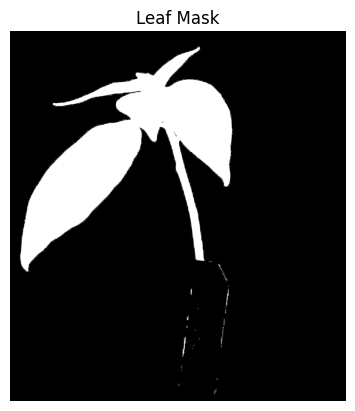

In [19]:
seg_img = cv2.imread("segmented/test2.JPG")
gray = cv2.cvtColor(seg_img, cv2.COLOR_BGR2GRAY)
_, mask = cv2.threshold(gray, 1, 255, cv2.THRESH_BINARY)
plt.imshow(mask, cmap="gray")
plt.title("Leaf Mask")
plt.axis("off")
plt.show()

In [20]:
metrics = compute_leaf_metrics(seg_img, mask)
print(metrics)

{'HGC%': 79.47, 'YB%': 0.21, 'DMG%': 67.64, 'HCI': 0.32, 'FM%': 20.32}


In [21]:
metric_to_grade(metrics)

g_HGC: 3, g_YB: 0, g_DMG: 4, g_HCI: 4, g_FM: 4


0